In [1]:
from collections import defaultdict
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import torchvision

import searchnets

#### Add "set size" to VSD / Pascal VOC dataset .csv
using the number of annotated bounding boxes as a proxy for set size

In [2]:
vsd_split_csv = pyprojroot.here() / 'data/Visual_Search_Difficulty_v1.0/VSD_dataset_split.csv'

In [3]:
vsd_df = pd.read_csv(vsd_split_csv)

add set size to VSD split csv

In [4]:
VSD_2012_ROOT = Path('/home/bart/Documents/data/voc/VOCdevkit/VOC2012')

In [5]:
ls /home/bart/Documents/data/voc/

VOCdevkit/  VOCtrainval_11-May-2012.tar


In [6]:
image_dir = VSD_2012_ROOT / 'JPEGImages'
annotation_dir = VSD_2012_ROOT / 'Annotations'

# splits_dir = os.path.join(VSD_2012_ROOT, 'ImageSets/Main')

# image_set='train'
# split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')
# with open(os.path.join(split_f), "r") as f:
#     file_names = [x.strip() for x in f.readlines()]

# # this should give us the same data frame since there are more file names
# # in the list we load from the text file than in the split in the dataframe currently
# # but we do it just to be sure we're using only files that are available
# vsd_df = vsd_df[vsd_df['img'].isin(file_names)]

In [7]:
vsd_df['root_output_dir'] = str(VSD_2012_ROOT)

In [8]:
vsd_df['img_file'] = ['JPEGImages/' + file_name + ".jpg" for file_name in vsd_df['img'].values]

In [9]:
vsd_df['meta_file'] = 'none'

In [10]:
vsd_df['xml_file'] = ['Annotations/' + file_name + ".xml" for file_name in vsd_df['img'].values]

In [11]:
target_transform = torchvision.transforms.Compose(
    [searchnets.transforms.ParseVocXml(),
     searchnets.transforms.ClassIntsFromXml()]
)

In [12]:
vsd_df['xml_path'] = vsd_df['root_output_dir'] + '/' + vsd_df['xml_file']

In [13]:
vsd_df['labels'] = vsd_df.xml_path.apply(target_transform)

In [14]:
vsd_df['set_size'] = vsd_df.labels.apply(len)

In [15]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

VOC_CLASS_INT_MAP = dict(zip(VOC_CLASSES, range(len(VOC_CLASSES))))
VOC_INT_CLASS_MAP = dict(zip(range(len(VOC_CLASSES)), VOC_CLASSES))

#### Now compute number of images for each set size, on a per-class basis

In [16]:
count_records = []
records = []

for label in range(20):
    label_as_set = {label}
    df_label = vsd_df[vsd_df.labels.apply(lambda x: bool(label_as_set.intersection(x)))]
    count_records.append(
        {
            'label_int': label,
            'label_str': VOC_INT_CLASS_MAP[label],
            'n_rows': len(df_label)
        }
    )
    set_sizes = df_label.set_size.values
    uniq_set_sizes, counts = np.unique(set_sizes, return_counts=True)
    for set_size, count in zip(uniq_set_sizes, counts):
        records.append(
            {
                'label_int': label,
                'label_str': VOC_INT_CLASS_MAP[label],
                'set_size': set_size,
                'count': count
            }
        )

df_label_rows = pd.DataFrame.from_records(count_records)
df_label_set_size = pd.DataFrame.from_records(records)

#### Plot coutn of images for each set size, per-class

/home/bart/.cache/pypoetry/virtualenvs/nicholson-prinz-2021-zheWulbu-py3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


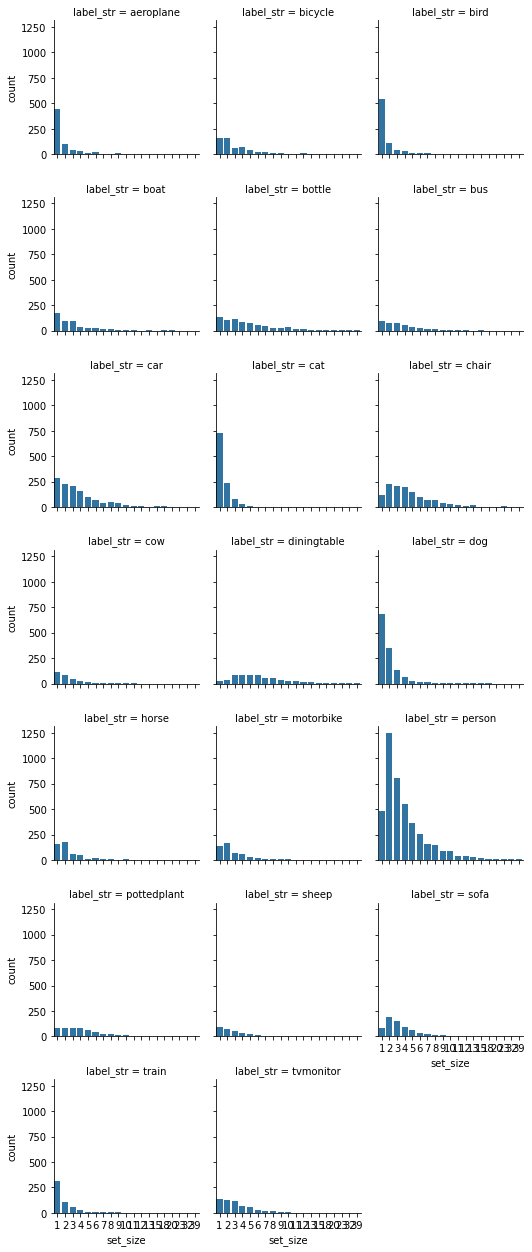

In [17]:
g = sns.FacetGrid(df_label_set_size, col="label_str", height=2.5, col_wrap=3)
g.map(sns.barplot, "set_size", "count")

#### Finally rank classes by the number of times they occur
If we use the $k$ most frequently occuring number of classes (for some $k$), we should be able to get an estimate of how much models behave when each class is treated as a target, without running into severe class imbalance issues

Looks like 5 is a good value for $k$, and the plot above suggests this will give us a good distribution of set sizes across classes.

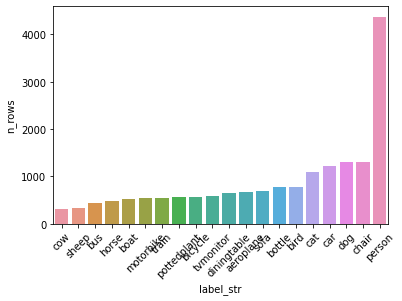

In [18]:
order = df_label_rows.sort_values('n_rows').label_str.values

sns.barplot(
    data=df_label_rows,
    order=order,
    x='label_str',
    y='n_rows'
)

plt.xticks(rotation=45);